In [208]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.rc('font', size=30)
plt.rc('axes', titlesize=30)
plt.rc('axes', labelsize=30)
plt.rc('xtick', labelsize=30)
plt.rc('ytick', labelsize=30)
plt.rc('legend', fontsize=30)
plt.rc('figure', titlesize=30)

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from scipy.stats import norm
from scipy.stats import laplace

import random
from tqdm import tqdm

In [257]:
returns = pd.read_csv('returns.csv')
returns = returns.fillna(0)
returns['date'] = returns['date'].astype(np.datetime64)
returns = returns.set_index('date')

In [258]:
returns

,MPWR,CCI,ESS,D,MRK,LYB,MLM,CAG,XEL,AMG,...,FL,ZBRA,THC,BR,EVRG,URBN,ANF,TIE,INTU,SPY
date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,0.008617,0.002673,-0.001422,-0.010919,0.015902,0.030153,0.004373,-0.004202,-0.010835,0.016249,...,0.006281,-0.001677,-0.033134,0.005345,0.000000,0.006894,0.001017,0.040086,-0.002469,0.015934
2012-01-04,-0.022360,0.002232,-0.016461,-0.008197,0.001041,0.037907,-0.000397,0.008374,-0.006582,0.002974,...,0.005409,-0.007558,-0.054445,-0.002685,0.000000,0.023784,-0.033332,-0.007093,-0.003043,0.001568
2012-01-05,0.022867,-0.000896,0.018621,-0.002108,0.010437,-0.014373,0.002369,-0.000761,0.004399,0.004400,...,0.025710,-0.001410,0.014928,0.003554,0.000000,-0.015134,-0.028995,-0.019374,0.004588,0.002663
2012-01-06,0.000000,0.001563,-0.004206,-0.010198,-0.006946,0.006150,-0.022404,-0.002664,-0.002921,-0.002133,...,0.008877,-0.008192,0.048315,-0.005259,0.000000,-0.011080,-0.021353,0.011868,0.013890,-0.002577
2012-01-09,0.026294,0.012886,-0.003637,-0.001366,-0.002110,-0.003796,0.009040,0.003818,0.000757,0.020093,...,0.002800,-0.004558,0.022043,0.007499,0.000000,0.040108,0.016019,0.005198,0.001137,0.002427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,0.022948,-0.005771,-0.001548,-0.008816,-0.004498,0.005077,0.018957,-0.010897,-0.006742,-0.000316,...,-0.033187,0.002192,0.003232,-0.009898,0.000794,-0.056878,-0.041292,0.000000,0.008123,0.002088
2021-04-27,-0.011632,-0.007309,0.000539,-0.004958,-0.002191,-0.000279,0.000361,-0.003772,-0.008512,0.018091,...,0.028386,0.006521,0.010379,0.001303,-0.009923,0.034706,0.026156,0.000000,-0.005189,-0.000216
2021-04-28,-0.019426,0.002436,-0.033900,-0.008295,-0.003492,0.013819,-0.006794,-0.001893,-0.002703,-0.009009,...,0.002375,-0.010264,0.043925,-0.001363,0.005725,0.000798,-0.000515,0.000000,-0.000768,-0.000287


In [6]:
prices = {}
funds = ['SPY', 'VTV', 'HDV', 'VDE', 'SDS']
for ticker in funds:
    df = pd.read_csv('{}.csv'.format(ticker))
    df['date'] = df['Date'].astype(np.datetime64)
    df['return'] = (df['Adj Close'] / df['Adj Close'].shift(1) - 1).fillna(0)
    prices[ticker] = df

# VaR

In [287]:
def norm_var(sample, window=252, alpha=0.95, n=1):
    size = len(sample) - window
    ans = np.zeros(size)
    for i in range(size):
        s = sample[i: i + window]
        ans[i] = norm.ppf(1 - alpha, n * np.mean(s), n * np.std(s))
    return ans

def p_norm_var(returns, weights, window=252, alpha=0.95, n=1):
    size = len(returns[0]) - window
    ans = np.zeros(size)
    for i in range(size):
        r = returns.take(range(i, i + window), axis=1)
        cov = np.cov(r)
        a = n * np.mean(r, axis=1) @ weights
        b = n * weights.T @ cov @ weights
        ans[i] = norm.ppf(1 - alpha, a, np.sqrt(b))
    return ans

def laplace_var(sample, window=252, alpha=0.95, n=1):
    size = len(sample) - window
    ans = np.zeros(size)
    for i in range(size):
        s = sample[i: i + window]
        ans[i] = laplace.ppf(1 - alpha, n * np.mean(s), n * np.std(s) / np.sqrt(2))
    return ans

def p_laplace_var(returns, weights, window=252, alpha=0.95, n=1):
    size = len(returns[0]) - window
    ans = np.zeros(size)
    for i in range(size):
        r = returns.take(range(i, i + window), axis=1)
        cov = np.cov(r)
        a = n * np.mean(r, axis=1) @ weights
        b = n * weights.T @ cov @ weights
        ans[i] = laplace.ppf(1 - alpha, a, np.sqrt(b) / np.sqrt(2))
    return ans

def hist_var(sample, window=252, alpha=0.95):
    size = len(sample) - window
    ans = np.zeros(size)
    for i in range(size):
        s = sample[i: i + window]
        ans[i] = np.percentile(s, (1 - alpha) * 100)
    return ans

def p_hist_var(returns, weights, window=252, alpha=0.95):
    return hist_var(returns.T @ weights, window, alpha)

def error_count(real, pred):
    count = 0;
    for i in range(len(real)):
        if real[i] < pred[i]:
            count += 1
    return (count / len(real)) * 100

In [305]:
def Var_estimate(sample, window=252, alpha=0.95, title=""):
    norm_ans = norm_var(sample, window)
    laplace_ans = laplace_var(sample, window)
    hist_ans = hist_var(sample, window)
    x = np.arange(len(sample) - window)
    real_ans = np.array(sample[window:])

    plt.figure(figsize=(17, 10))
    plt.title(title)
    plt.plot(x, real_ans, label="real")
    plt.plot(x, norm_ans, alpha=0.7, label="norm")
    plt.plot(x, laplace_ans, alpha=0.7, label="laplace")
    plt.plot(x, hist_ans, alpha=0.7, label="hist")
    plt.legend()
    plt.show()
    
    print("\"Пробои\" нормального VaR происходят в {}% случаев".format(round(error_count(real_ans, norm_ans), 2)))
    print("\"Пробои\" лапласового VaR происходят в {}% случаев".format(round(error_count(real_ans, laplace_ans), 2)))
    print("\"Пробои\" исторического VaR происходят в {}% случаев".format(round(error_count(real_ans, hist_ans), 2)))

def p_Var_estimate(returns, weights, window=252, alpha=0.95):
    norm_ans = p_norm_var(returns, weights)
    laplace_ans = p_laplace_var(returns, weights)
    hist_ans = p_hist_var(returns, weights)
    x = np.arange(len(returns[0]) - window)
    real_ans = np.array(returns.take(range(window, len(returns[0])), axis=1).T @ weights)
    
    plt.figure(figsize=(17, 10))
    plt.plot(x, real_ans, label="real")
    plt.plot(x, norm_ans, alpha=0.4, label="norm")
    plt.plot(x, laplace_ans, alpha=0.4, label="laplace")
    plt.plot(x, hist_ans, alpha=0.4, label="hist")
    plt.legend()
    plt.show()
    
    print("\"Пробои\" нормального VaR происходят в {}% случаев".format(round(error_count(real_ans, norm_ans), 2)))
    print("\"Пробои\" лапласового VaR происходят в {}% случаев".format(round(error_count(real_ans, laplace_ans), 2)))
    print("\"Пробои\" исторического VaR происходят в {}% случаев".format(round(error_count(real_ans, hist_ans), 2)))

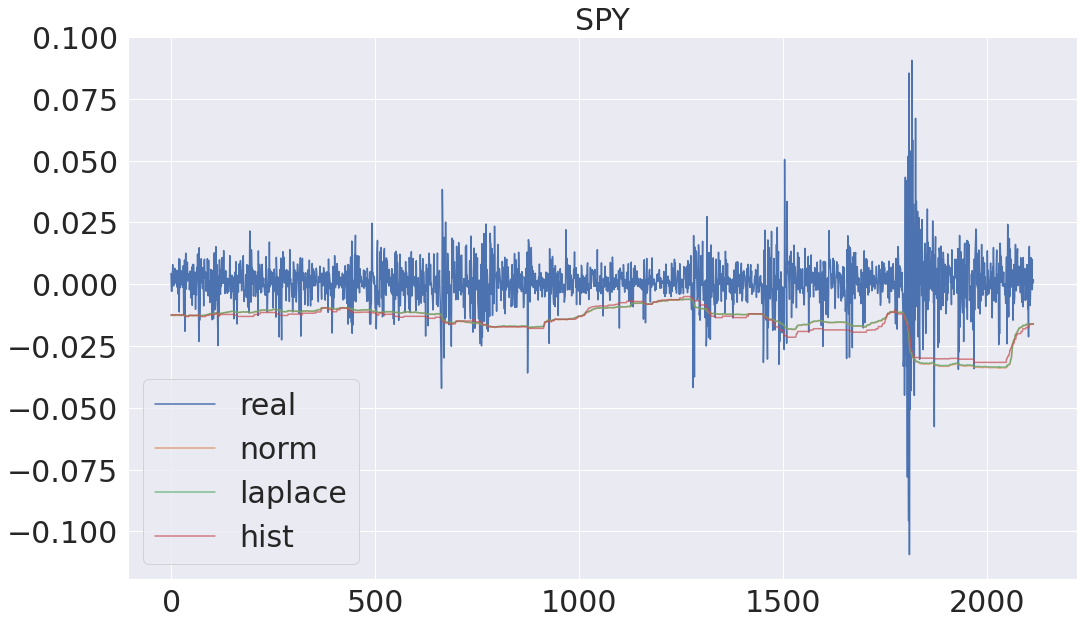

"Пробои" нормального VaR происходят в 5.72% случаев
"Пробои" лапласового VaR происходят в 5.82% случаев
"Пробои" исторического VaR происходят в 5.39% случаев


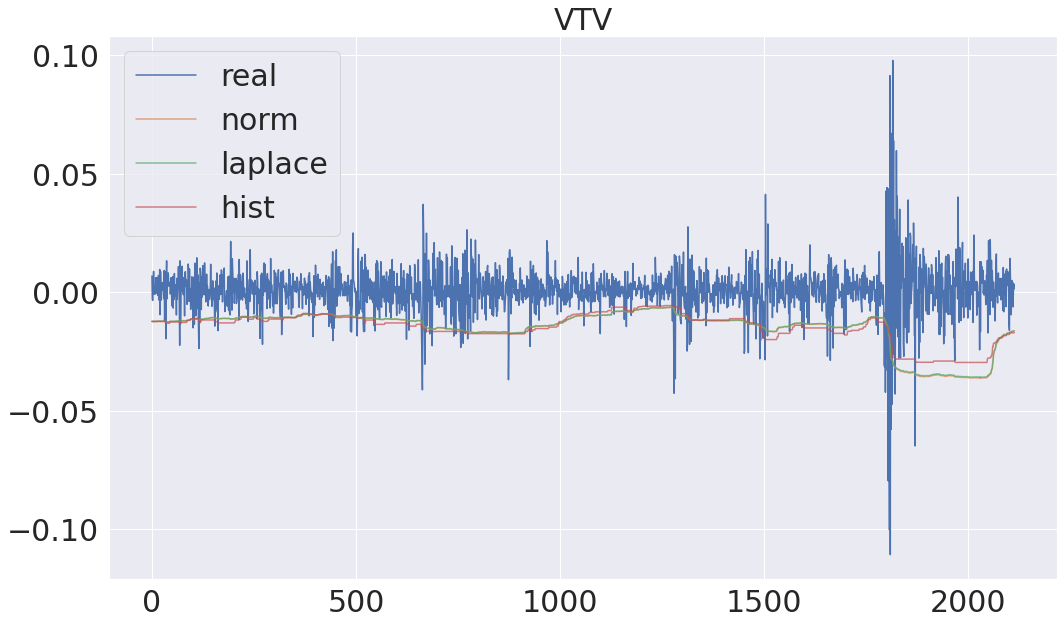

"Пробои" нормального VaR происходят в 5.44% случаев
"Пробои" лапласового VaR происходят в 5.48% случаев
"Пробои" исторического VaR происходят в 5.15% случаев


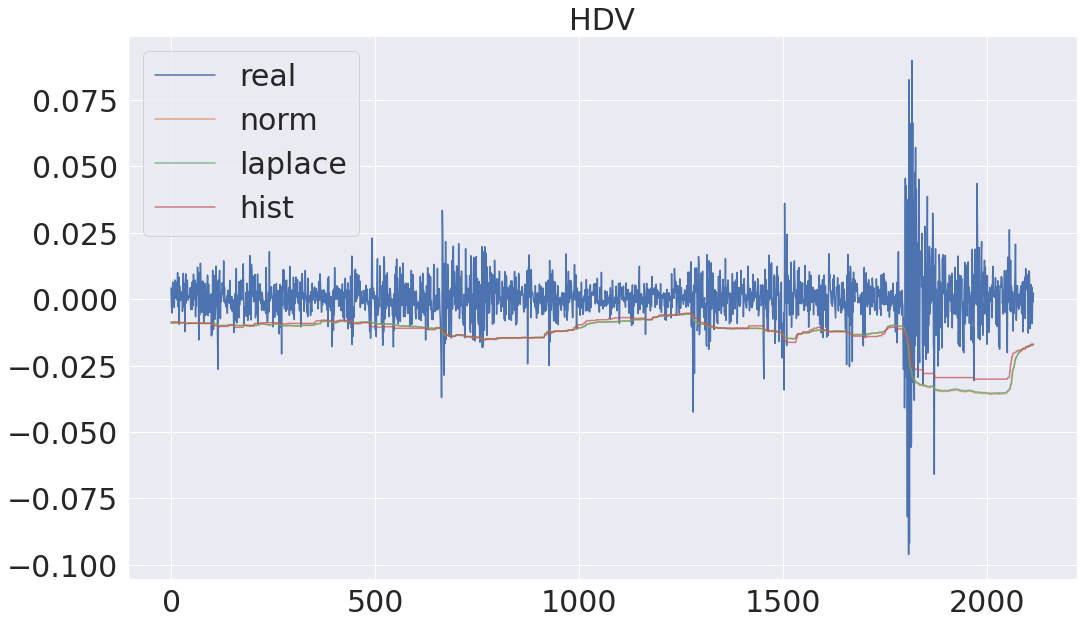

"Пробои" нормального VaR происходят в 5.44% случаев
"Пробои" лапласового VaR происходят в 5.48% случаев
"Пробои" исторического VaR происходят в 5.67% случаев


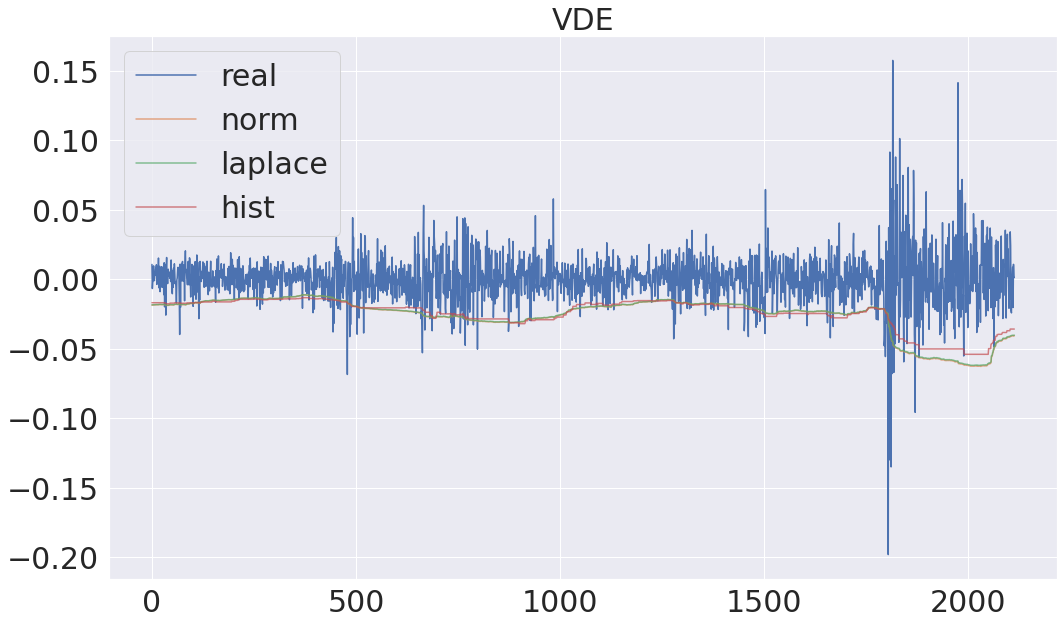

"Пробои" нормального VaR происходят в 6.1% случаев
"Пробои" лапласового VaR происходят в 6.19% случаев
"Пробои" исторического VaR происходят в 6.43% случаев


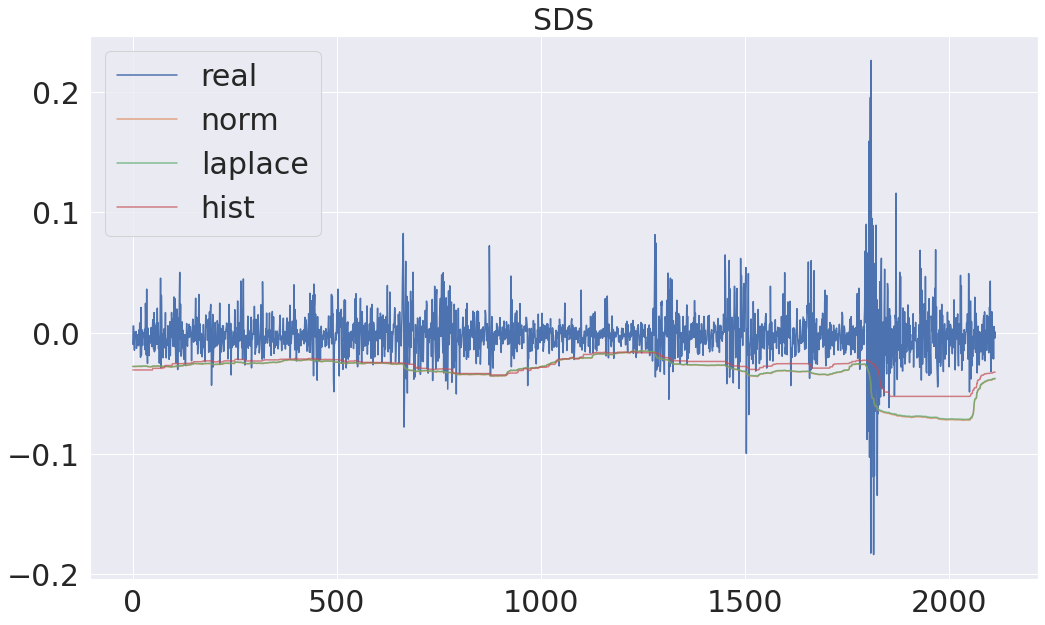

"Пробои" нормального VaR происходят в 4.21% случаев
"Пробои" лапласового VaR происходят в 4.4% случаев
"Пробои" исторического VaR происходят в 5.48% случаев


In [306]:
for ticker in funds:
    Var_estimate(prices[ticker]['return'], title=ticker)

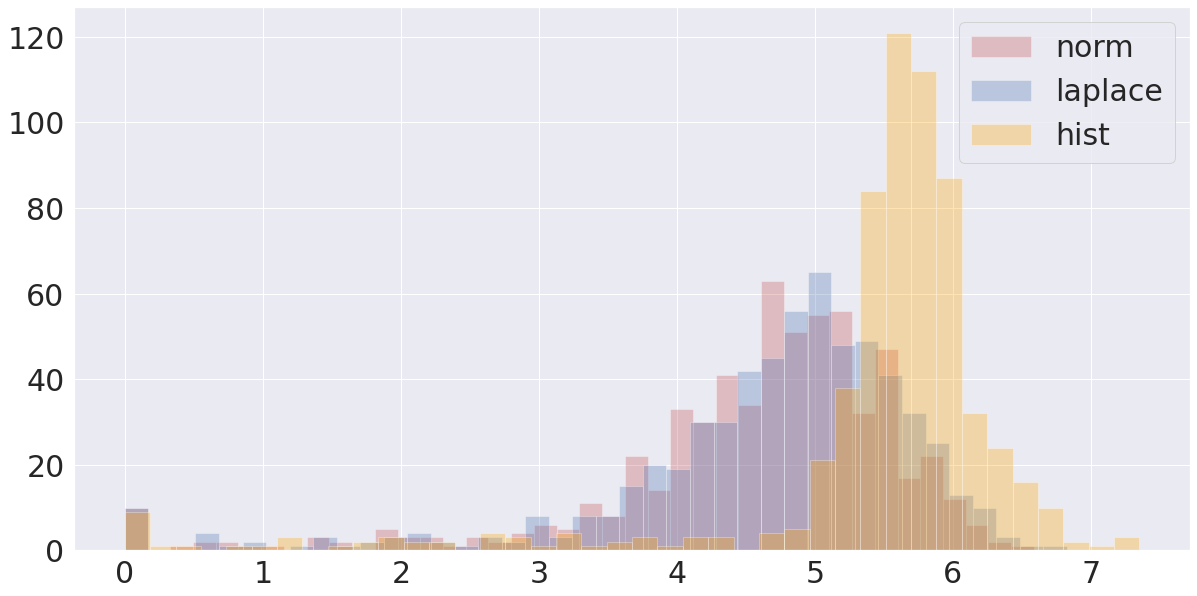

In [171]:
window = 252
tickers = returns.columns
norm_res = np.zeros(len(tickers))
laplace_res = np.zeros(len(tickers))
hist_res = np.zeros(len(tickers))
for i, ticker in enumerate(tickers):
    sample = np.array(returns[ticker])
    norm_res[i] = error_count(np.array(sample[window:]), norm_var(sample))
    laplace_res[i] = error_count(np.array(sample[window:]), laplace_var(sample))
    hist_res[i] = error_count(np.array(sample[window:]), hist_var(sample))
plt.figure(figsize=(20, 10))
plt.hist(norm_res, color='r', alpha=0.3, bins=40, label="norm")
plt.hist(laplace_res, color='b', alpha=0.3, bins=40, label="laplace")
plt.hist(hist_res, color='orange', alpha=0.3, bins=40, label="hist")
plt.legend()
plt.show()

In [173]:
print("Norm mean={}, std={}".format(np.mean(norm_res), np.std(norm_res)))
print("Laplace mean={}, std={}".format(np.mean(laplace_res), np.std(laplace_res)))
print("Yist mean={}, std={}".format(np.mean(hist_res), np.std1 active(hist_res)))

Norm mean=4.5532774238405676, std=1.1178267267772999
Laplace mean=4.658898710592206, std=1.141489251993893
Yist mean=5.447620982074849, std=1.1280719884739272


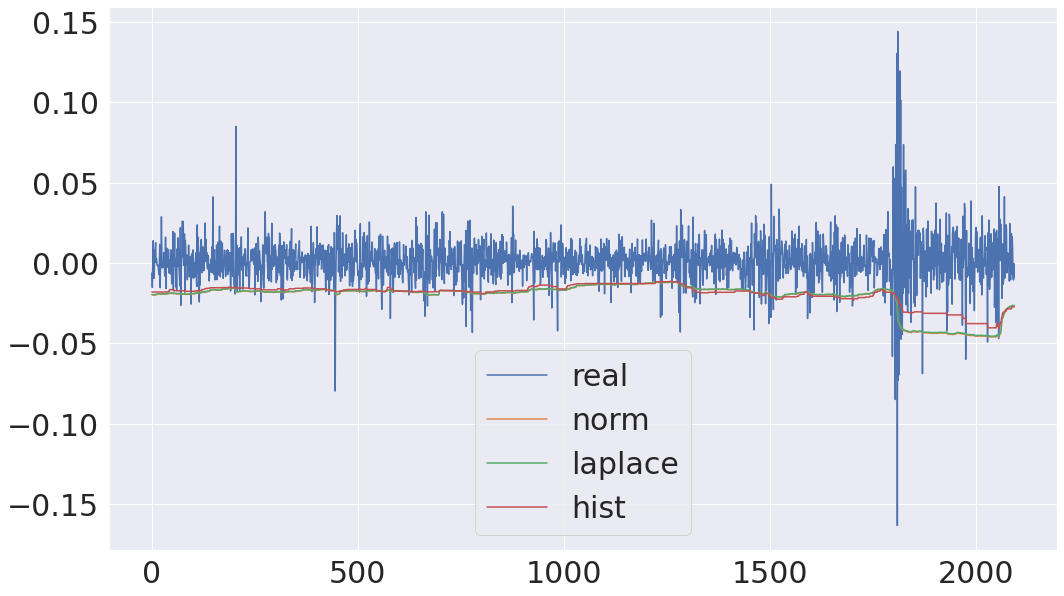

"Пробои" нормального VaR происходят в 5.06% случаев
"Пробои" лапласового VaR происходят в 5.11% случаев
"Пробои" исторического VaR происходят в 5.39% случаев


In [286]:
sample = returns[["MPWR", "CCI", "D"]]
weights = np.array([0.5, 0.3, 0.2])

p_Var_estimate(np.array(sample).T, weights)

 54%|█████▍    | 54/100 [02:27<02:06,  2.75s/it]/home/paromad/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2023: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/paromad/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2024: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
100%|██████████| 100/100 [04:32<00:00,  2.72s/it]


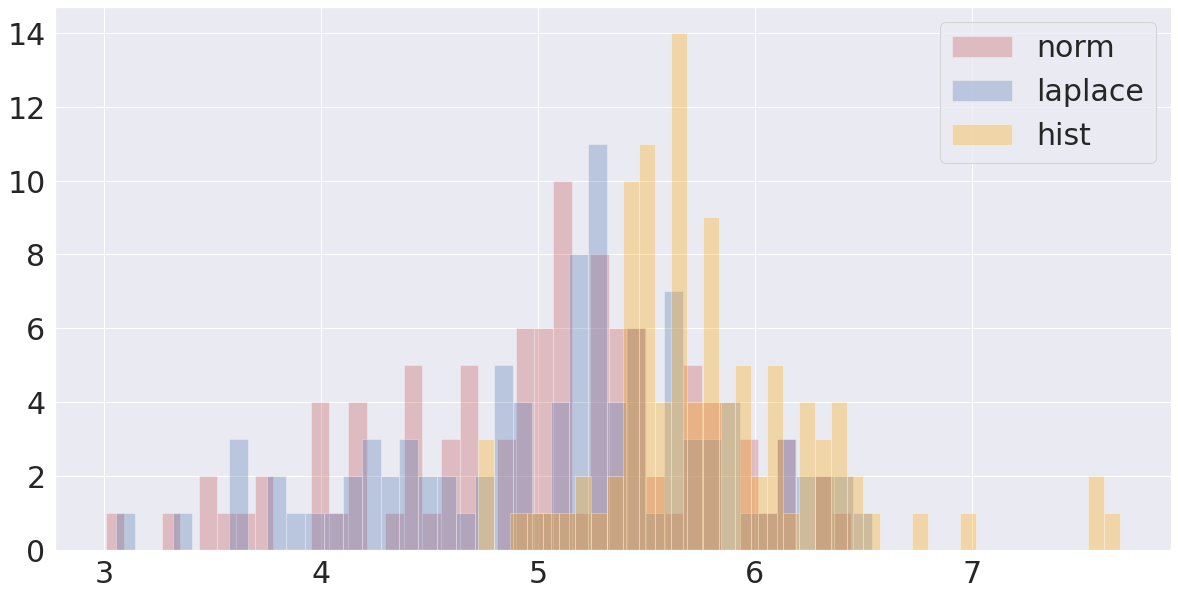

In [273]:
N = 100
p_norm_res = np.zeros(N)
p_laplace_res = np.zeros(N)
p_hist_res = np.zeros(N)
tickers = returns.columns
for i in tqdm(range(N)):
    n = random.randint(2, 10)
    names = random.sample(list(tickers), n)
    sample = np.array(returns[names]).T
    k = 1
    weights = np.zeros(n)
    for j in range(n):
        weights[j] = random.uniform(0, k)
        k -= weights[j]
    p_norm_res[i] = error_count(np.array(sample.take(range(window, len(sample[0])), axis=1).T @ weights), p_norm_var(sample, weights))
    p_laplace_res[i] = error_count(np.array(sample.take(range(window, len(sample[0])), axis=1).T @ weights), p_laplace_var(sample, weights))
    p_hist_res[i] = error_count(np.array(sample.take(range(window, len(sample[0])), axis=1).T @ weights), p_hist_var(sample, weights))

plt.figure(figsize=(20, 10))
plt.hist(p_norm_res, color='r', alpha=0.3, bins=40, label="norm")
plt.hist(p_laplace_res, color='b', alpha=0.3, bins=40, label="laplace")
plt.hist(p_hist_res, color='orange', alpha=0.3, bins=40, label="hist")
plt.legend()
plt.show()

In [276]:
print("Norm mean={}, std={}".format(np.mean(p_norm_res), np.std(p_norm_res)))
print("Laplace mean={}, std={}".format(np.mean(p_laplace_res), np.std(p_laplace_res)))
print("Yist mean={}, std={}".format(np.mean(p_hist_res), np.std(p_hist_res)))

Norm mean=5.010023866348448, std=0.7221665212174108
Laplace mean=5.131742243436754, std=0.7392096638587274
Yist mean=5.7952267303102625, std=0.5216681527116008


100%|██████████| 100/100 [03:50<00:00,  2.30s/it]


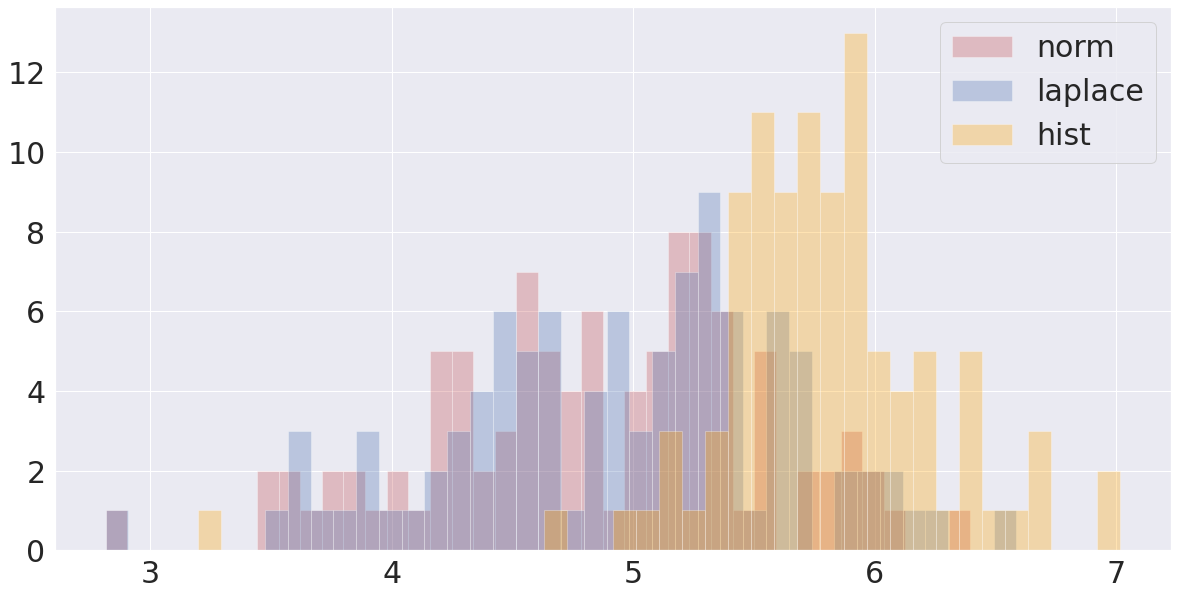

In [274]:
N = 100
p_2_norm_res = np.zeros(N)
p_2_laplace_res = np.zeros(N)
p_2_hist_res = np.zeros(N)
tickers = returns.columns
for i in tqdm(range(N)):
    n = 2
    names = random.sample(list(tickers), n)
    sample = np.array(returns[names]).T
    k = 1
    weights = np.zeros(n)
    for j in range(n):
        weights[j] = random.uniform(0, k)
        k -= weights[j]
    p_2_norm_res[i] = error_count(np.array(sample.take(range(window, len(sample[0])), axis=1).T @ weights), p_norm_var(sample, weights))
    p_2_laplace_res[i] = error_count(np.array(sample.take(range(window, len(sample[0])), axis=1).T @ weights), p_laplace_var(sample, weights))
    p_2_hist_res[i] = error_count(np.array(sample.take(range(window, len(sample[0])), axis=1).T @ weights), p_hist_var(sample, weights))

plt.figure(figsize=(20, 10))
plt.hist(p_2_norm_res, color='r', alpha=0.3, bins=40, label="norm")
plt.hist(p_2_laplace_res, color='b', alpha=0.3, bins=40, label="laplace")
plt.hist(p_2_hist_res, color='orange', alpha=0.3, bins=40, label="hist")
plt.legend()
plt.show()

In [277]:
print("Norm mean={}, std={}".format(np.mean(p_2_norm_res), np.std(p_2_norm_res)))
print("Laplace mean={}, std={}".format(np.mean(p_2_laplace_res), np.std(p_2_laplace_res)))
print("Yist mean={}, std={}".format(np.mean(p_2_hist_res), np.std(p_2_hist_res)))

Norm mean=4.839140811455847, std=0.6748323024066081
Laplace mean=4.948448687350836, std=0.694934791684625
Yist mean=5.763245823389021, std=0.48816432378372904


100%|██████████| 100/100 [17:18<00:00, 10.38s/it]  


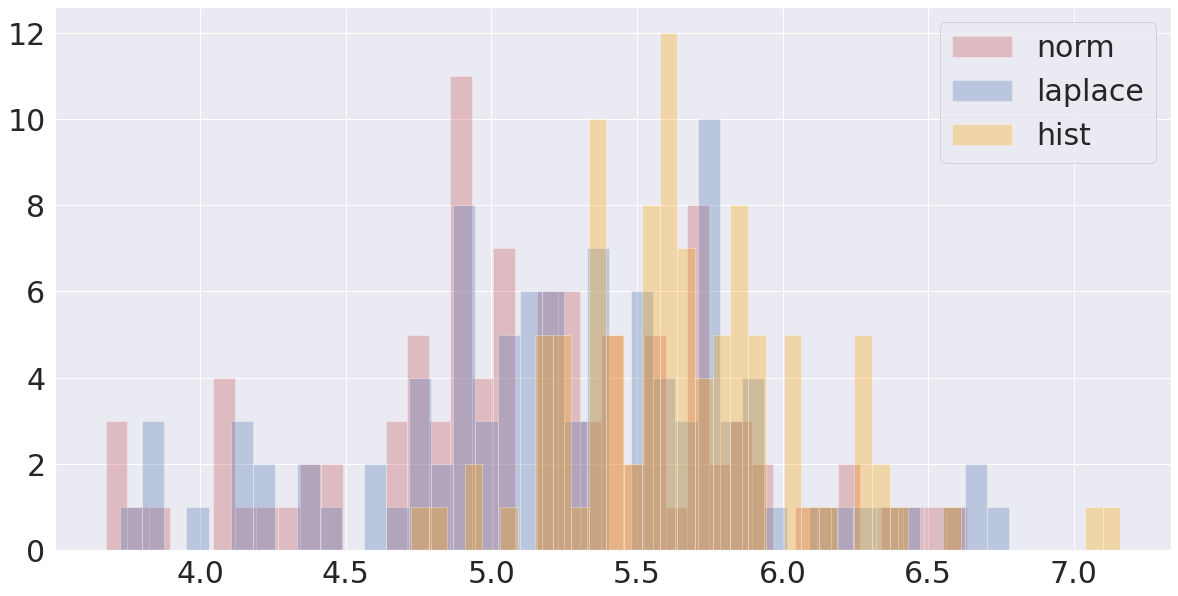

In [275]:
N = 100
p_20_norm_res = np.zeros(N)
p_20_laplace_res = np.zeros(N)
p_20_hist_res = np.zeros(N)
tickers = returns.columns
for i in tqdm(range(N)):
    n = 20
    names = random.sample(list(tickers), n)
    sample = np.array(returns[names]).T
    k = 1
    weights = np.zeros(n)
    for j in range(n):
        weights[j] = random.uniform(0, k)
        k -= weights[j]
    p_20_norm_res[i] = error_count(np.array(sample.take(range(window, len(sample[0])), axis=1).T @ weights), p_norm_var(sample, weights))
    p_20_laplace_res[i] = error_count(np.array(sample.take(range(window, len(sample[0])), axis=1).T @ weights), p_laplace_var(sample, weights))
    p_20_hist_res[i] = error_count(np.array(sample.take(range(window, len(sample[0])), axis=1).T @ weights), p_hist_var(sample, weights))

plt.figure(figsize=(20, 10))
plt.hist(p_20_norm_res, color='r', alpha=0.3, bins=40, label="norm")
plt.hist(p_20_laplace_res, color='b', alpha=0.3, bins=40, label="laplace")
plt.hist(p_20_hist_res, color='orange', alpha=0.3, bins=40, label="hist")
plt.legend()
plt.show()

In [278]:
print("Norm mean={}, std={}".format(np.mean(p_20_norm_res), np.std(p_20_norm_res)))
print("Laplace mean={}, std={}".format(np.mean(p_20_laplace_res), np.std(p_20_laplace_res)))
print("Yist mean={}, std={}".format(np.mean(p_20_hist_res), np.std(p_20_hist_res)))

Norm mean=5.14272076372315, std=0.6404233879596953
Laplace mean=5.257756563245823, std=0.6521193114604151
Yist mean=5.672076372315034, std=0.40632021908437105


In [282]:
print("------For random portfolio------------------------")
print("Norm mean={}, std={}".format(np.mean(p_norm_res), np.std(p_norm_res)))
print("Laplace mean={}, std={}".format(np.mean(p_laplace_res), np.std(p_laplace_res)))
print("Yist mean={}, std={}".format(np.mean(p_hist_res), np.std(p_hist_res)))
print("\n\n------For portfolio of 2 actives------------------")
print("Norm mean={}, std={}".format(np.mean(p_2_norm_res), np.std(p_2_norm_res)))
print("Laplace mean={}, std={}".format(np.mean(p_2_laplace_res), np.std(p_2_laplace_res)))
print("Yist mean={}, std={}".format(np.mean(p_2_hist_res), np.std(p_2_hist_res)))
print("\n\n------For portfolio of 20 actives-----------------")
print("Norm mean={}, std={}".format(np.mean(p_20_norm_res), np.std(p_20_norm_res)))
print("Laplace mean={}, std={}".format(np.mean(p_20_laplace_res), np.std(p_20_laplace_res)))
print("Yist mean={}, std={}".format(np.mean(p_20_hist_res), np.std(p_20_hist_res)))

------For random portfolio------------------------
Norm mean=5.010023866348448, std=0.7221665212174108
Laplace mean=5.131742243436754, std=0.7392096638587274
Yist mean=5.7952267303102625, std=0.5216681527116008


------For portfolio of 2 actives------------------
Norm mean=4.839140811455847, std=0.6748323024066081
Laplace mean=4.948448687350836, std=0.694934791684625
Yist mean=5.763245823389021, std=0.48816432378372904


------For portfolio of 20 actives-----------------
Norm mean=5.14272076372315, std=0.6404233879596953
Laplace mean=5.257756563245823, std=0.6521193114604151
Yist mean=5.672076372315034, std=0.40632021908437105


 42%|████▏     | 125/300 [08:52<11:25,  3.92s/it]/home/paromad/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2023: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/paromad/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2024: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
100%|██████████| 300/300 [24:17<00:00,  4.86s/it]


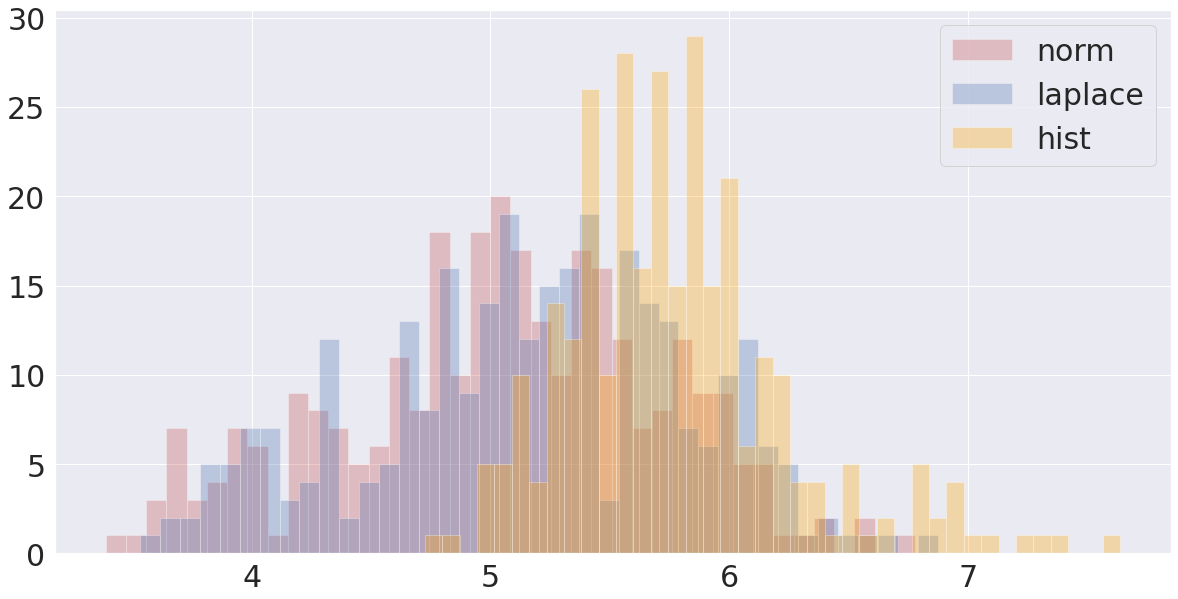

In [309]:
N = 300
norm_res = np.zeros(N)
laplace_res = np.zeros(N)
hist_res = np.zeros(N)
tickers = returns.columns
for i in tqdm(range(N)):
    n = random.randint(2, 10)
    names = random.sample(list(tickers), n)
    sample = np.array(returns[names]).T
    k = 1
    weights = np.zeros(n)
    for j in range(n):
        weights[j] = random.uniform(0, k)
        k -= weights[j]
    norm_res[i] = error_count(np.array(sample.take(range(window, len(sample[0])), axis=1).T @ weights), p_norm_var(sample, weights))
    laplace_res[i] = error_count(np.array(sample.take(range(window, len(sample[0])), axis=1).T @ weights), p_laplace_var(sample, weights))
    hist_res[i] = error_count(np.array(sample.take(range(window, len(sample[0])), axis=1).T @ weights), p_hist_var(sample, weights))

plt.figure(figsize=(20, 10))
plt.hist(norm_res, color='r', alpha=0.3, bins=40, label="norm")
plt.hist(laplace_res, color='b', alpha=0.3, bins=40, label="laplace")
plt.hist(hist_res, color='orange', alpha=0.3, bins=40, label="hist")
plt.legend()
plt.show()